<a href="https://colab.research.google.com/github/cuhkrsdi/newspaper-analytics/blob/main/Visualization%2C_wordcloud_graph_(Public).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualize NLP result with frequency chart and word cloud

- Read the result of named-entity recognition
- prepare function which used the manually built filters to extract the valid result
- display word occurrence with frequency charts and word clouds

###Import libraries

In [1]:
# retrieve data
import json
from urllib.request import urlopen

# Ignore SSL for url demo
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# frequency charts
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# word clouds
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

# color schemes for word cloud 
import random
from palettable.colorbrewer.sequential import YlGnBu_9, BuPu_9, YlOrRd_9, PuBuGn_9, GnBu_9 # 5 sets of colors

###Read the result and filters

In [2]:
# Here the result shares EXACTLY THE SAME structure as the sample demo in the "data_preprocessing_and_NLP (Public).ipynb", the only difference is the total amount of data
# read result
url_result = "https://dsprojects.lib.cuhk.edu.hk/media/filer_public/ea/69/ea69bab5-552f-4dd3-a5ef-02aa79faa7a7/ymd_frequency001.json"
result_file = urlopen(url_result)
ymd_freq_dict = json.loads(result_file.read().decode("utf-8"))

In [3]:
# Structure:    ymd_freq_dict = {ymd: {word: {type1: freq, type2:freq, ...}, word: {...}}, ymd: {...}}
print(len(ymd_freq_dict.keys()))

3250


In [4]:
# read filters, expect: 'PERSON_list', 'PERSON_dict', 'ORG_list', 'ORG_dict', 'EVENT_list', 'EVENT_dict', 'ymd_to_pid_dict', 'pid_to_parent', 'GPE_dict', 'GPE_list'
url_filterdict = "https://dsprojects.lib.cuhk.edu.hk/media/filer_public/f6/71/f671a0da-1533-409a-a014-ec31d4aeac1c/filteranddict.json" 
filter_file = urlopen(url_filterdict)
dict_list_filters = json.loads(filter_file.read().decode("utf-8"))

In [5]:
# Structure:    dict_list_filters = {'list_name': [...], 'dict_name': {...}}
print(dict_list_filters.keys())

dict_keys(['PERSON_list', 'PERSON_dict', 'ORG_list', 'ORG_dict', 'EVENT_list', 'EVENT_dict', 'ymd_to_pid_dict', 'pid_to_parent', 'GPE_dict', 'GPE_list'])


###Define function for filtering

In [6]:
# Input: str of NER type, pre-made inclusion filter of the NER type, pre-made replacement filter of the NER type, nested dictionary of NLP result
# Output: dictionary of word: frequency of occurrence

def filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict):

  temp_type_gpe_dict = dict()

  filter_list = dict_list_filters[filter_inclusion]
  filter_dict = dict_list_filters[filter_replacement]

  # for each loops
  for ymd_key in ymd_freq_dict.keys():
    for ner_word in ymd_freq_dict[ymd_key].keys():
      for ner_type in ymd_freq_dict[ymd_key][ner_word].keys():

        # check validity 1) Type 2) ner_word exist in filter list
        if (ner_type == type_to_filter) and (ner_word in filter_list):

          if ner_word not in filter_dict:
            if ner_word not in temp_type_gpe_dict:
              temp_type_gpe_dict[ner_word] = ymd_freq_dict[ymd_key][ner_word][ner_type]
            else:
              temp_type_gpe_dict[ner_word] = temp_type_gpe_dict.get(ner_word, None) + ymd_freq_dict[ymd_key][ner_word][ner_type]

          else: # ner_word in filter_dict:
            corrected_ner_word = filter_dict[ner_word]
            if corrected_ner_word not in temp_type_gpe_dict:
              temp_type_gpe_dict[corrected_ner_word] = ymd_freq_dict[ymd_key][ner_word][ner_type]
            else:
              temp_type_gpe_dict[corrected_ner_word] = temp_type_gpe_dict.get(corrected_ner_word, None) + ymd_freq_dict[ymd_key][ner_word][ner_type]
              
  return temp_type_gpe_dict

###Download Fonts for Traditional Chinese characters

In [7]:
# Download the Font for Traditional Chinese characters
!wget "https://github.com/cuhkrsdi/newspaper-analytics/raw/main/NotoSansTC-Regular.otf"

--2022-07-04 08:45:19--  https://github.com/cuhkrsdi/newspaper-analytics/raw/main/NotoSansTC-Regular.otf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuhkrsdi/newspaper-analytics/main/NotoSansTC-Regular.otf [following]
--2022-07-04 08:45:19--  https://raw.githubusercontent.com/cuhkrsdi/newspaper-analytics/main/NotoSansTC-Regular.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5766468 (5.5M) [application/octet-stream]
Saving to: ‘NotoSansTC-Regular.otf’

NotoSansTC-Regular. 100%[===================>]   5.50M  --.-KB/s    in 0.1s    

2022-07-04 08:45:20 (50.4 MB/s) - ‘NotoSansTC-Regular.ot

###Frequency chart - PERSON

In [8]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all PERSON type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""

# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "PERSON"
# Selected Filter
filter_inclusion = 'PERSON_list'
filter_replacement = 'PERSON_dict'
        
temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)


In [9]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
df

,PERSON,occurrence
0,毛澤東,6910
1,陳孝威,4500
2,尼克遜,3784
3,赫魯歇夫,2303
4,艾森豪,1940
...,...,...
827,凌雲,22
828,胡璉,22
829,陳質平,22
830,宇垣,22


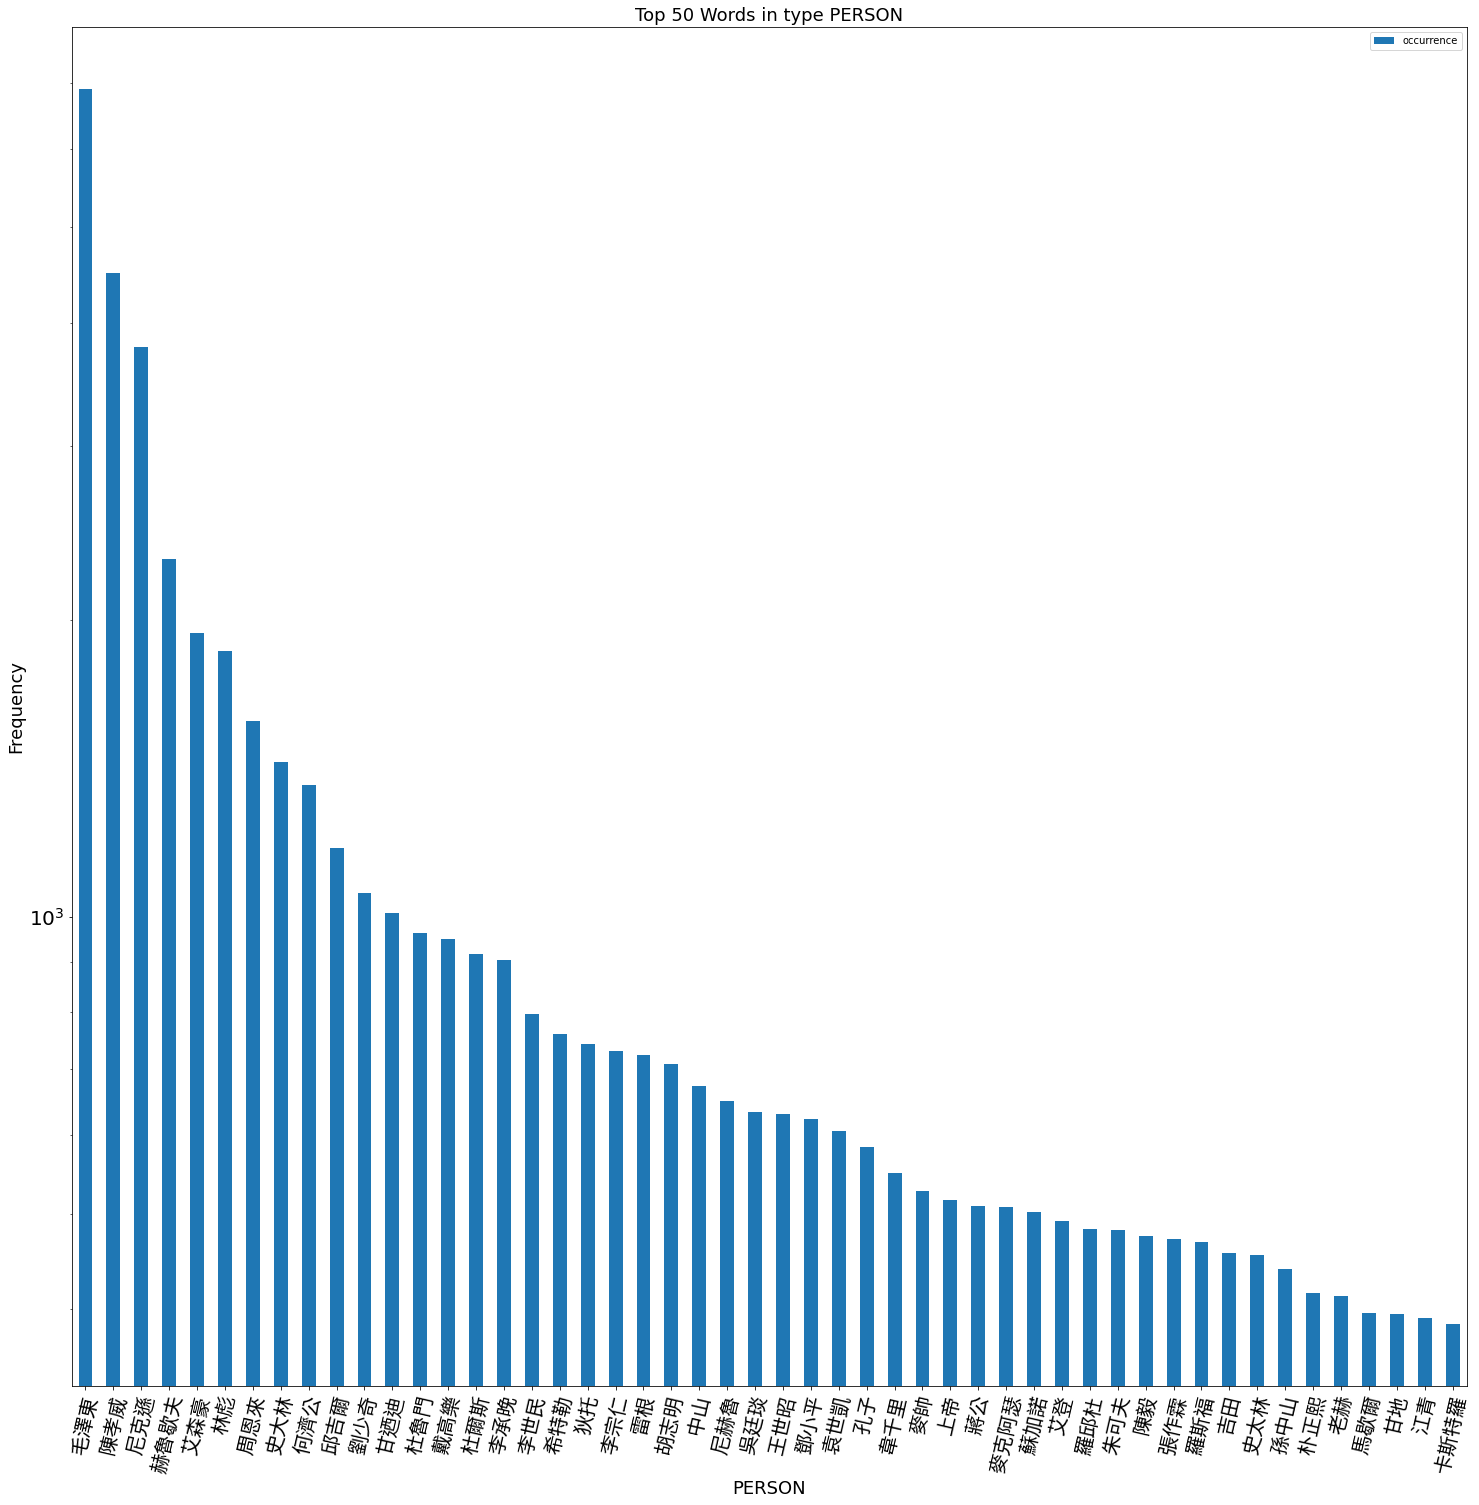

In [20]:
from matplotlib.ticker import ScalarFormatter
# Load font
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') 

# modift the length of chart
length = 50

df_sliced = df[0 :length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True)
plt.title('Top 50 Words in type PERSON', fontsize=18)

xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize=20, rotation ='horizontal')
plt.xlabel('PERSON', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

#plt.yscale('log')




# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)

###Frequency chart - ORG

In [21]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all ORG type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""

# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "ORG"
# Selected Filter
filter_inclusion = 'ORG_list'
filter_replacement = 'ORG_dict'


temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

In [22]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
df

,ORG,occurrence
0,中共,64925
1,共黨,10278
2,毛共,7983
3,反共,6335
4,越共,4112
...,...,...
929,婦聯會,7
930,遠東軍,7
931,文滙報,7
932,第四野戰軍,7


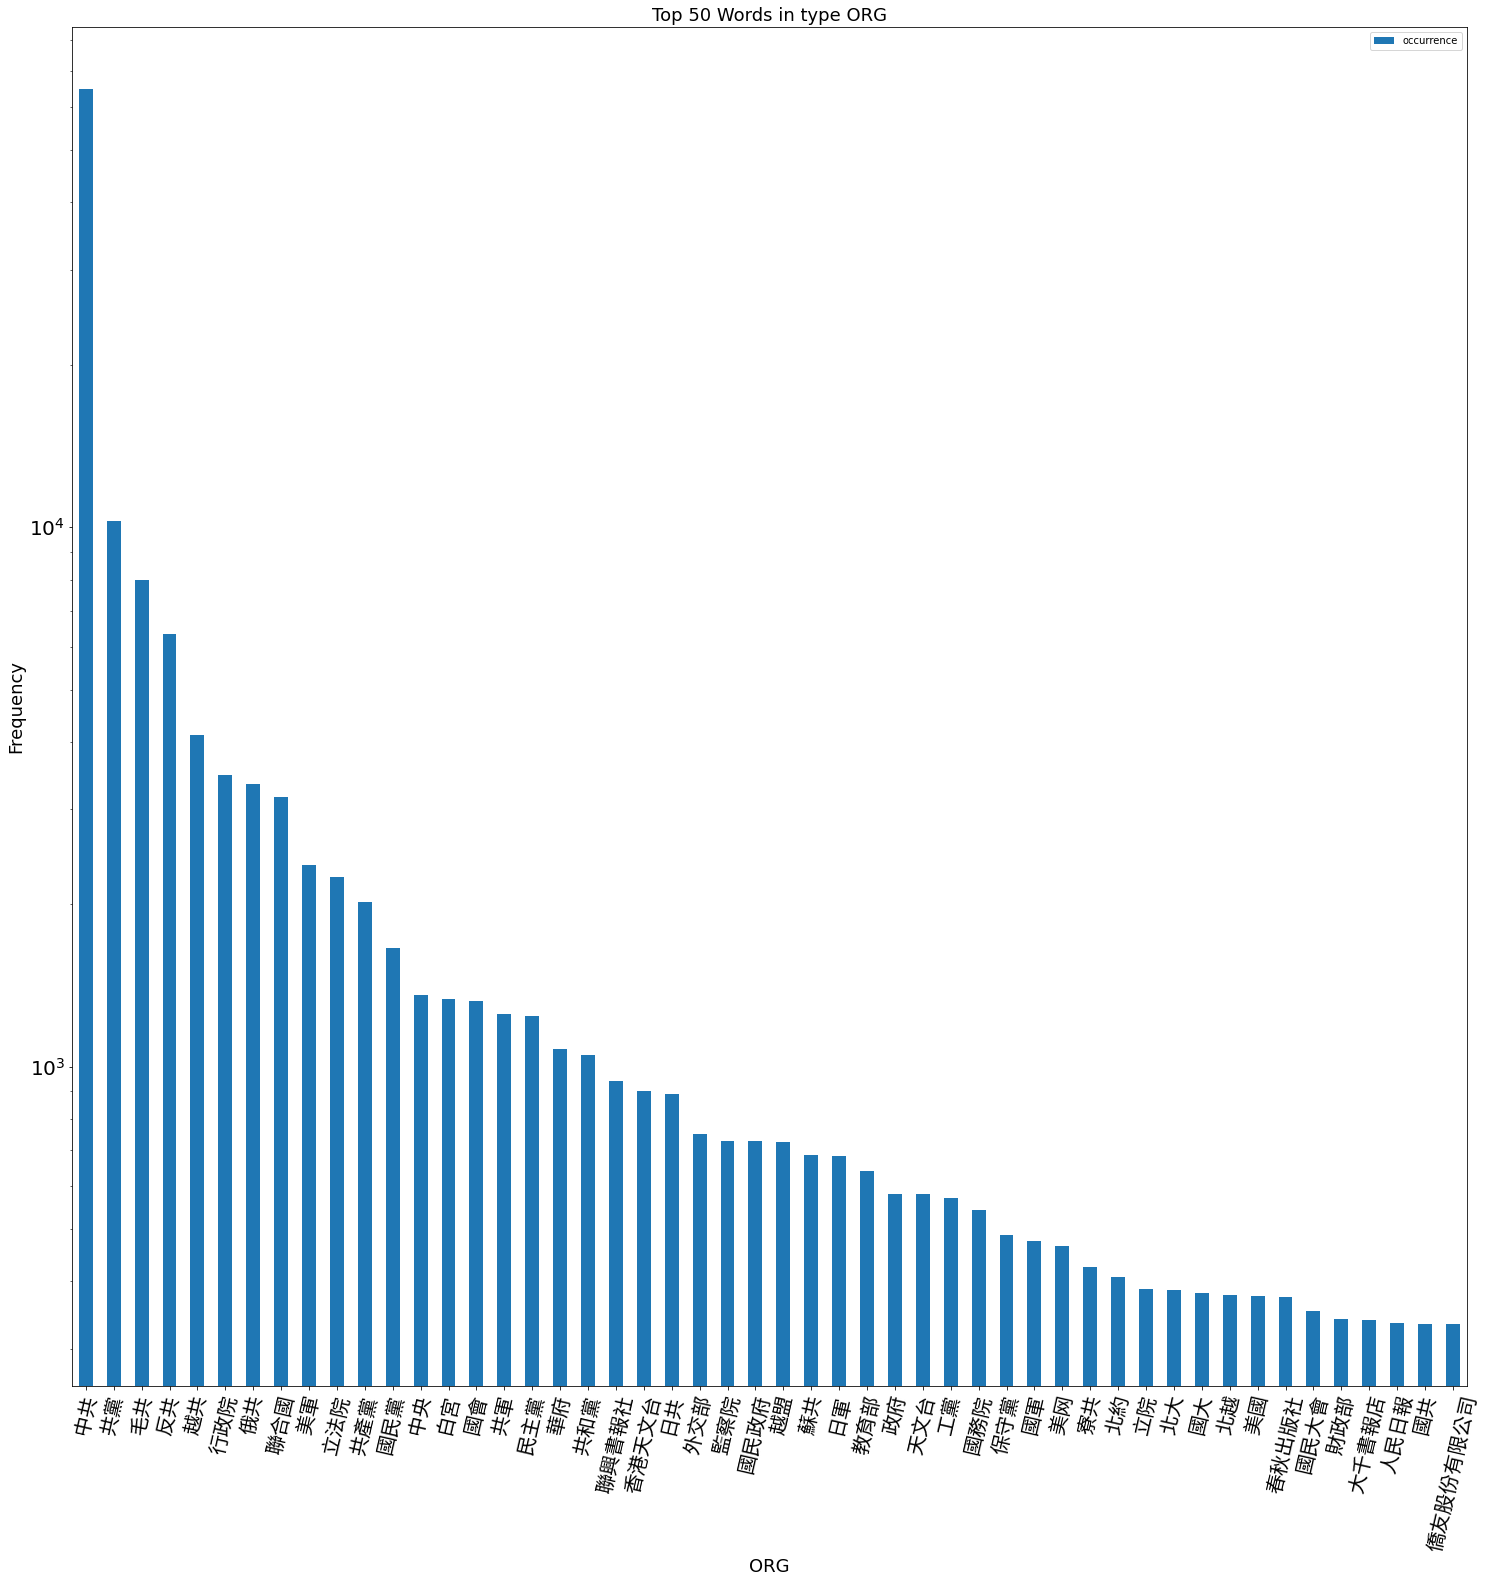

In [24]:
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') # from installed path 

# modify the length of chart
length = 50

df_sliced = df[0:length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True) 
plt.title('Top 50 Words in type ORG', fontsize=18)


xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize = 20, rotation ='horizontal')
plt.xlabel('ORG', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)


###Frequency chart - EVENT

In [26]:
"""
# From:
# ymd_freq_dict = {ymd: {word: {ner_type: freq, ner_type: freq, ...}}}

# To: freq of all EVENT type
# temp_type_gpe_dict = {ner_word: freq, ner_word: freq}
"""


# MODIFY Before Run!!!!!!!!
# Selected Type
type_to_filter = "EVENT"
# Selected Filter
filter_inclusion = 'EVENT_list'
filter_replacement = 'EVENT_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

In [27]:
# organize dictionary by frequency of occurrencefrom highest and turn into dataframe
ordered_dict = OrderedDict(sorted(temp_type_gpe_dict.items(), key=lambda t: -t[1]))
df = pd.DataFrame(list(ordered_dict.items()))
df.columns = [type_to_filter, 'occurrence']
df

,EVENT,occurrence
0,越戰,1714
1,韓戰,966
2,文化大革命,921
3,抗戰,781
4,文革,764
...,...,...
677,中元普渡,2
678,中元祭,2
679,水雷案,2
680,韓航事件,2


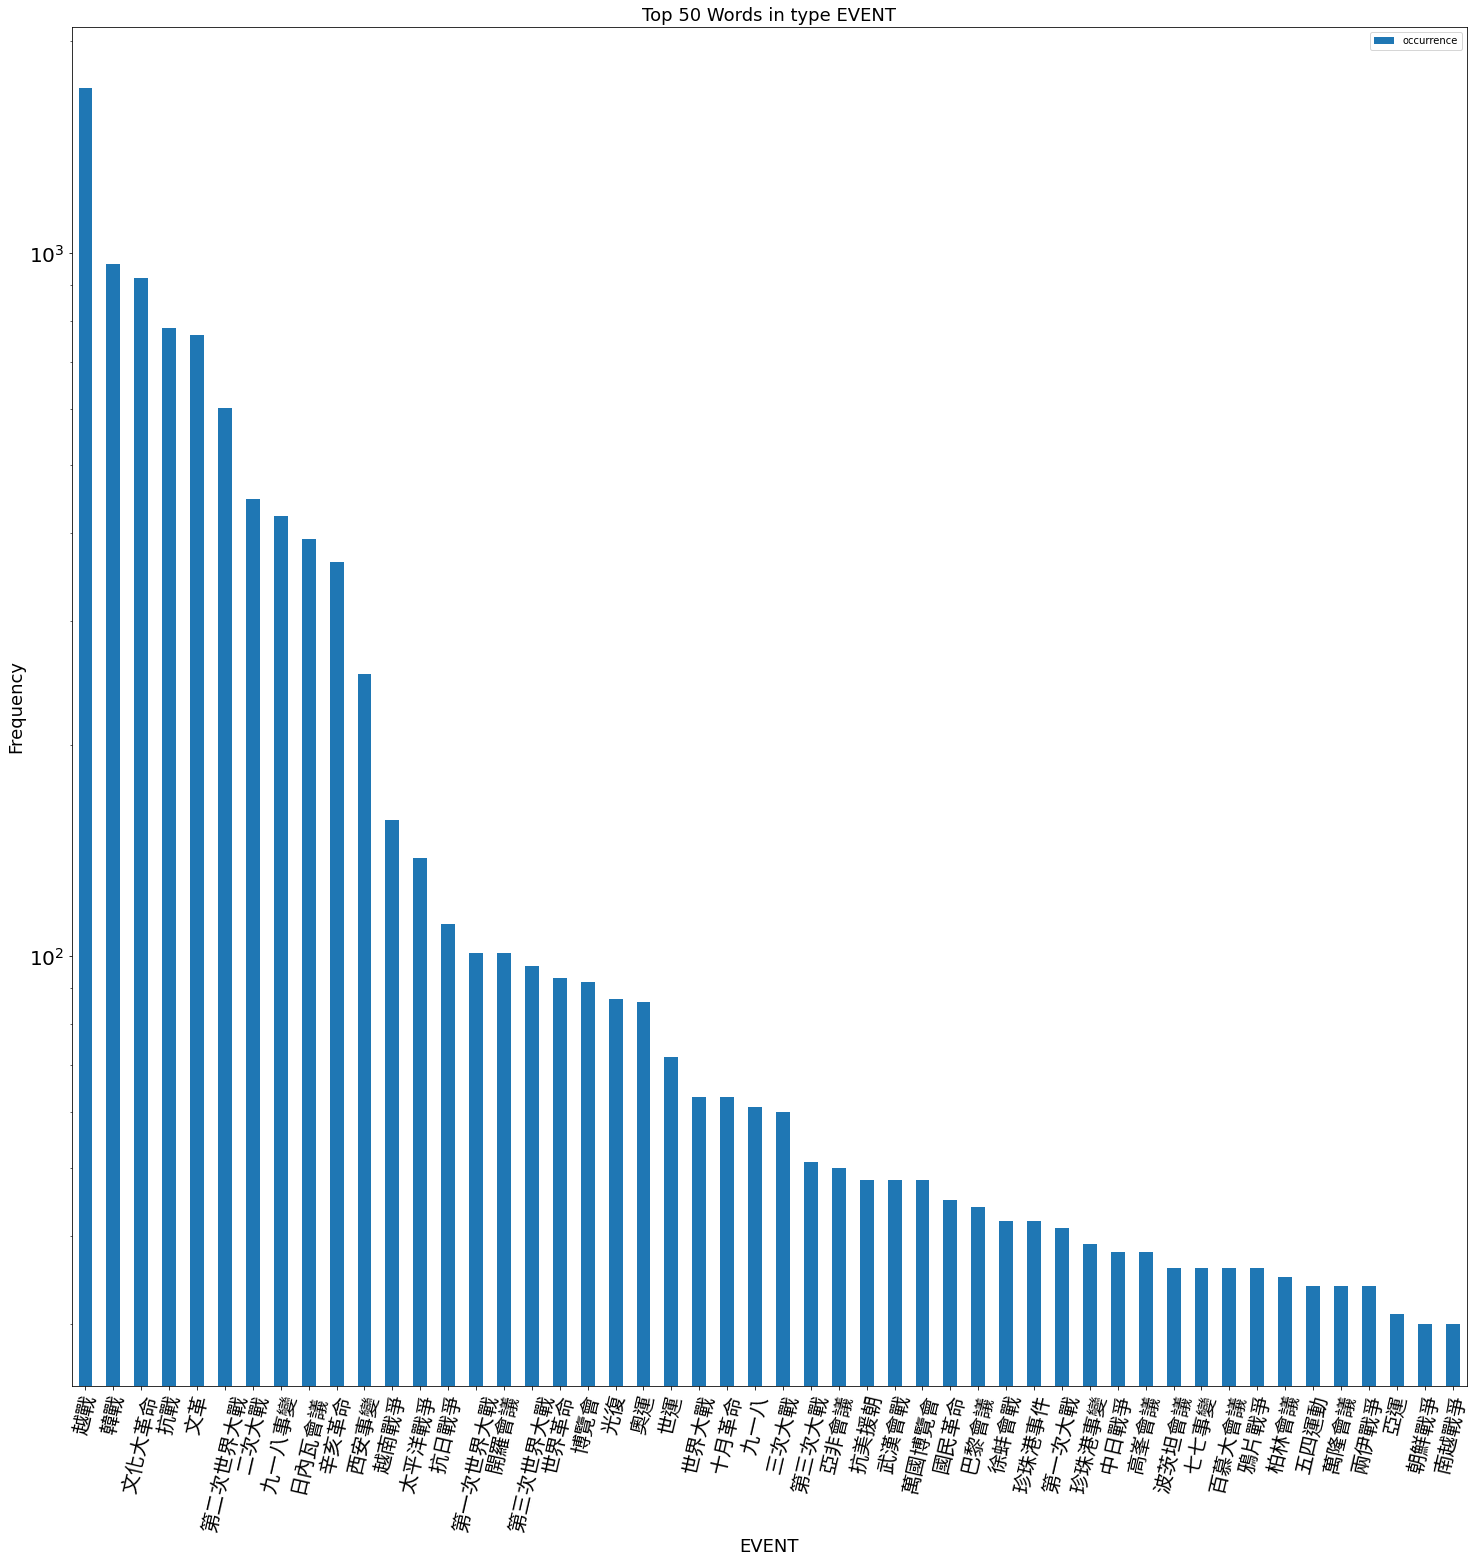

In [28]:
fprop = fm.FontProperties(fname='/content/NotoSansTC-Regular.otf') # from installed path 

# modift length of chart
length = 50

df_sliced = df[0:length]

df_sliced.plot.bar(x=type_to_filter, y="occurrence", rot=77, logy=True)
plt.title('Top 50 Words in type EVENT', fontsize=18)


xticks = list(df_sliced[type_to_filter])
x = [i for i in range(length)]
plt.xticks(x, xticks, fontproperties=fprop, fontsize=20) # rotation ='vertical'
plt.yticks(fontsize = 20, rotation ='horizontal')
plt.xlabel('EVENT', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# plt.figure(figsize=(8, 2))
plt.rcParams["figure.figsize"] = (25,25)
plt.show(block=True)


###Colour change functions for word clouds

In [29]:
def a(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(YlGnBu_9.colors[random.randint(1,8)])  # start from index 1 to exclude the lightest colour 
def b(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(BuPu_9.colors[random.randint(1,8)])
def c(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(YlOrRd_9.colors[random.randint(1,8)])
def d(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(PuBuGn_9.colors[random.randint(1,8)])
def e(word, font_size, position, orientation, random_state=None, **kwargs):
  return tuple(GnBu_9.colors[random.randint(1,8)]) 
def f(word, font_size, position, orientation, random_state=None, **kwargs): # wordcloud documentation sample
  return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)



###Word Cloud - PERSON

In [ ]:
# PERSON
# Selected Type
type_to_filter = "PERSON"
# Selected Filter
filter_inclusion = 'PERSON_list'
filter_replacement = 'PERSON_dict'
        
temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

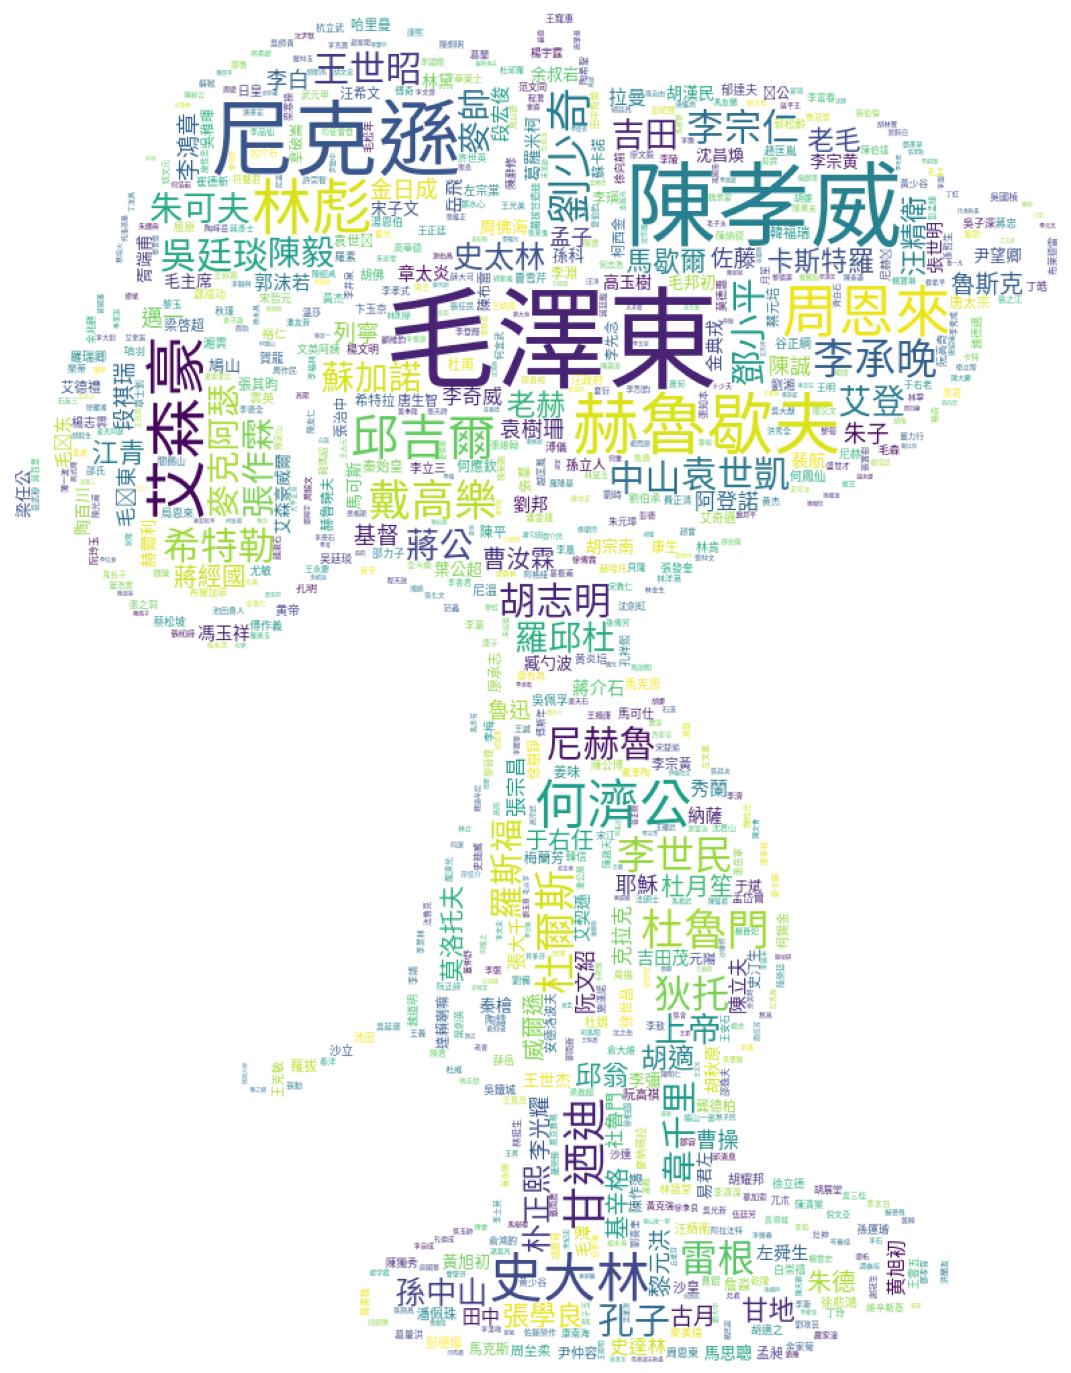

In [ ]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

not_snoopy = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/42/8d/428df22a-8a12-4a89-8634-1534112eb67a/funnynotsnoopypng.png'


image_ulr = urlretrieve(not_snoopy, "sample.png")
icon = Image.open("sample.png")


mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "white", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)



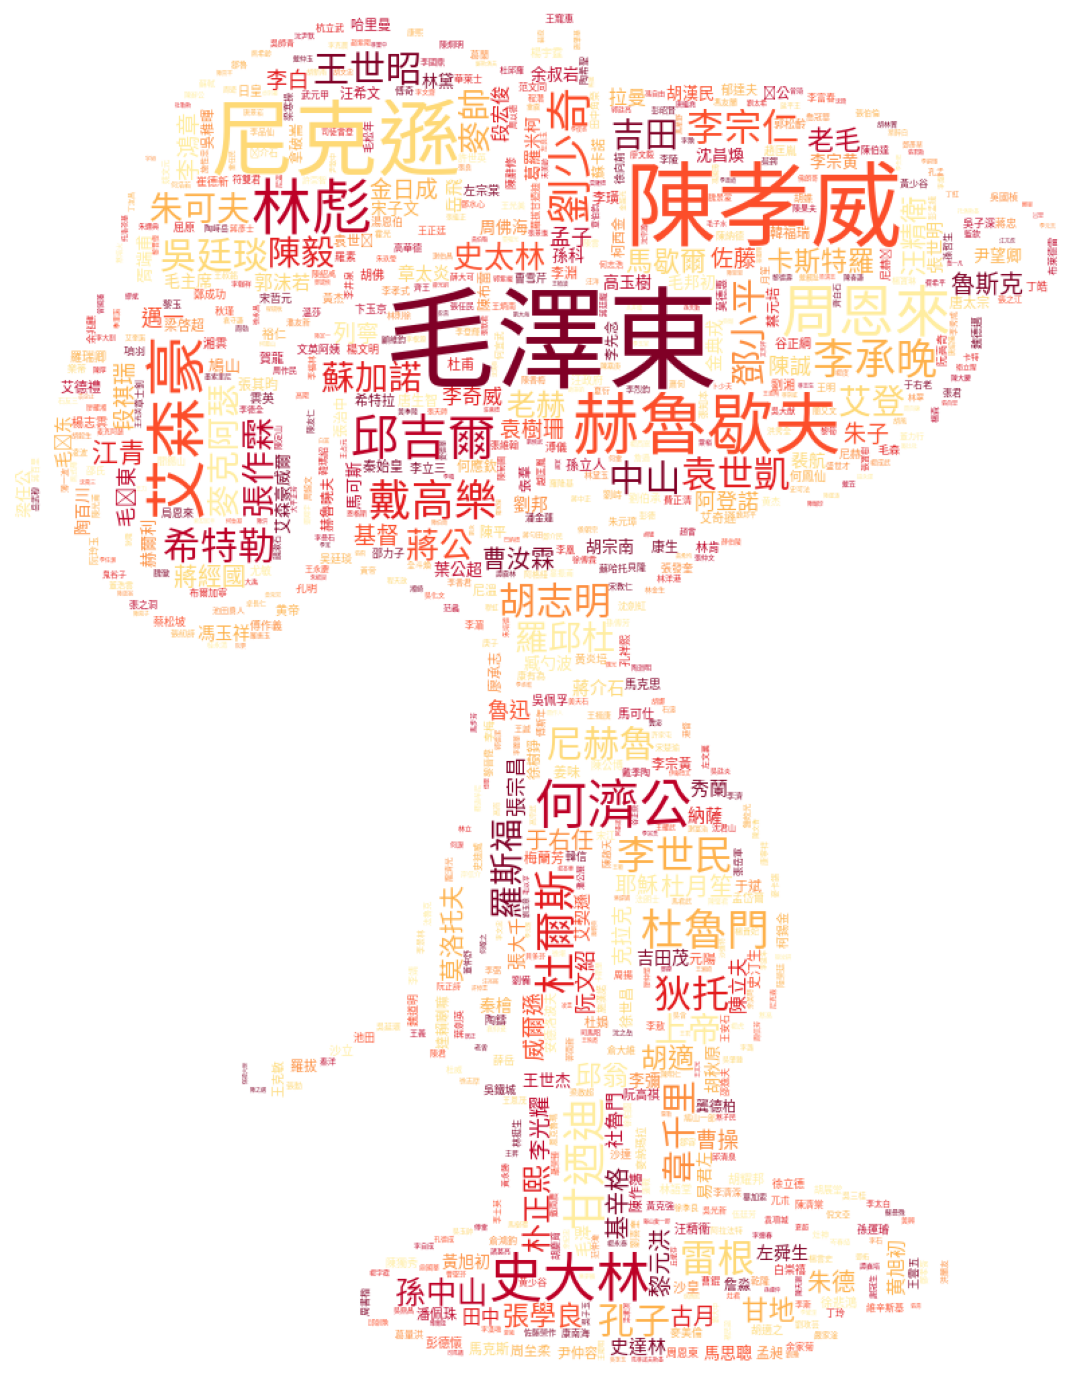

In [ ]:
# run to replace the word cloud with randomly selected color scheme
wc.recolor(color_func=random.choice([a, b, c, d, e, f]), random_state=2)  # a, b, c, d, e, f
plt.axis('off')
plt.imshow(wc)

###Word Cloud - ORG

In [ ]:
# ORG
# Selected Type
type_to_filter = "ORG"
# Selected Filter
filter_inclusion = 'ORG_list'
filter_replacement = 'ORG_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

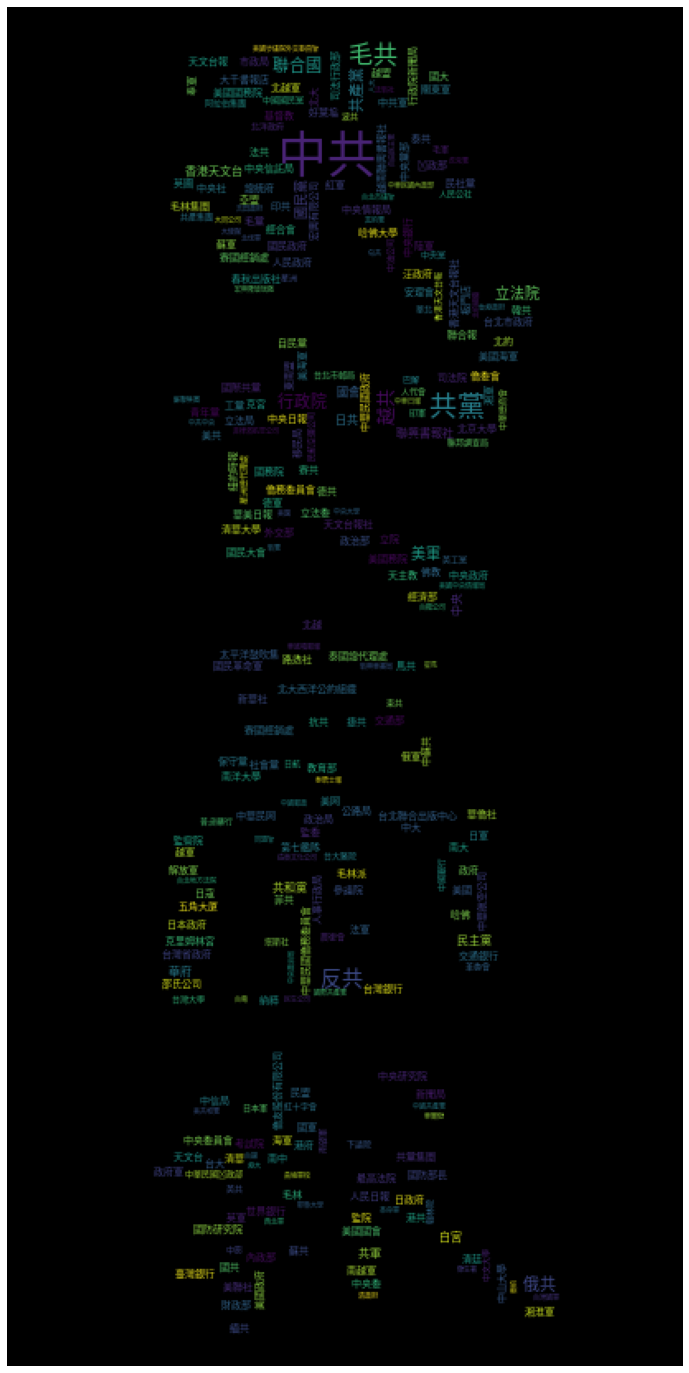

In [ ]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

or_logo = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/cd/e2/cde206f2-f6a9-414f-9705-06282da807b7/observatoryreview3dpaintertest001.png'

image_ulr = urlretrieve(or_logo, "sample.png")
icon = Image.open("sample.png")

mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "black", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)


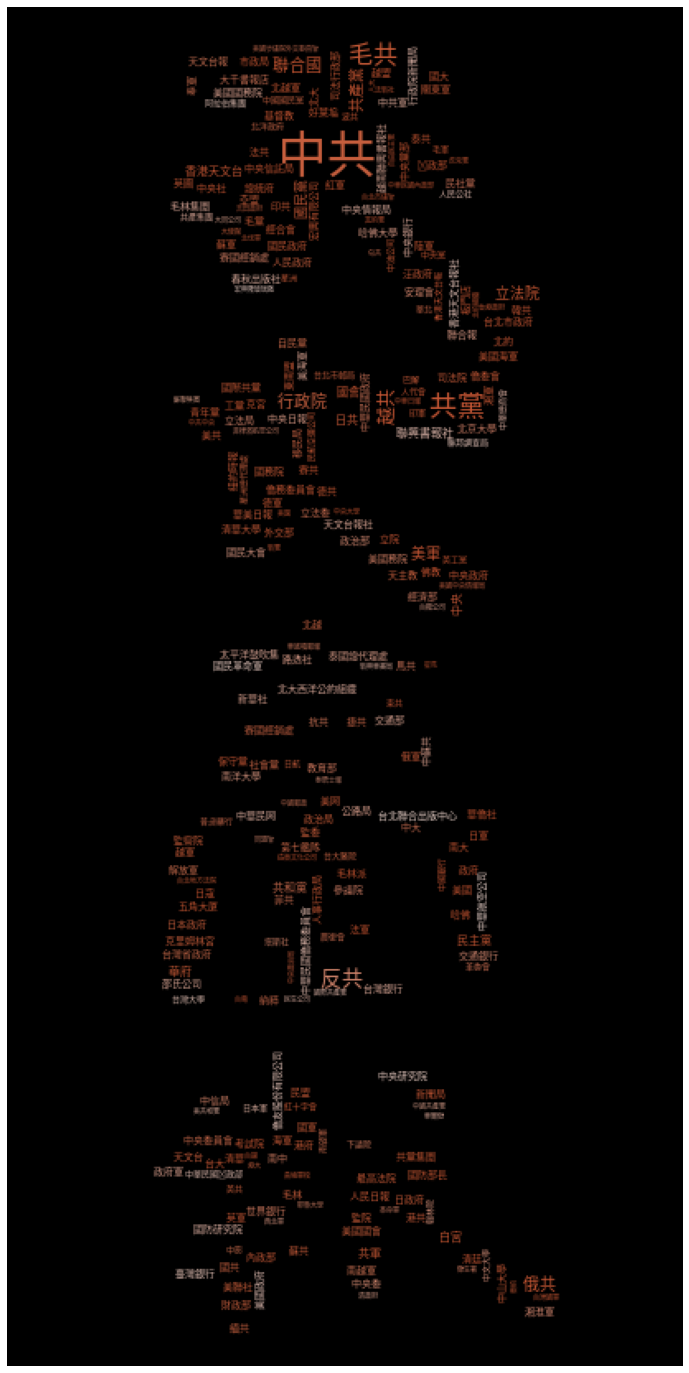

In [ ]:
# show the word cloud with original color of the image
wc.recolor(color_func=image_colors, random_state=2)
plt.axis('off')
plt.imshow(wc)

###Word Cloud - EVENT

In [ ]:
# EVENT
# Selected Type
type_to_filter = "EVENT"
# Selected Filter
filter_inclusion = 'EVENT_list'
filter_replacement = 'EVENT_dict'

temp_type_gpe_dict = filtering(type_to_filter, filter_inclusion, filter_replacement, ymd_freq_dict)

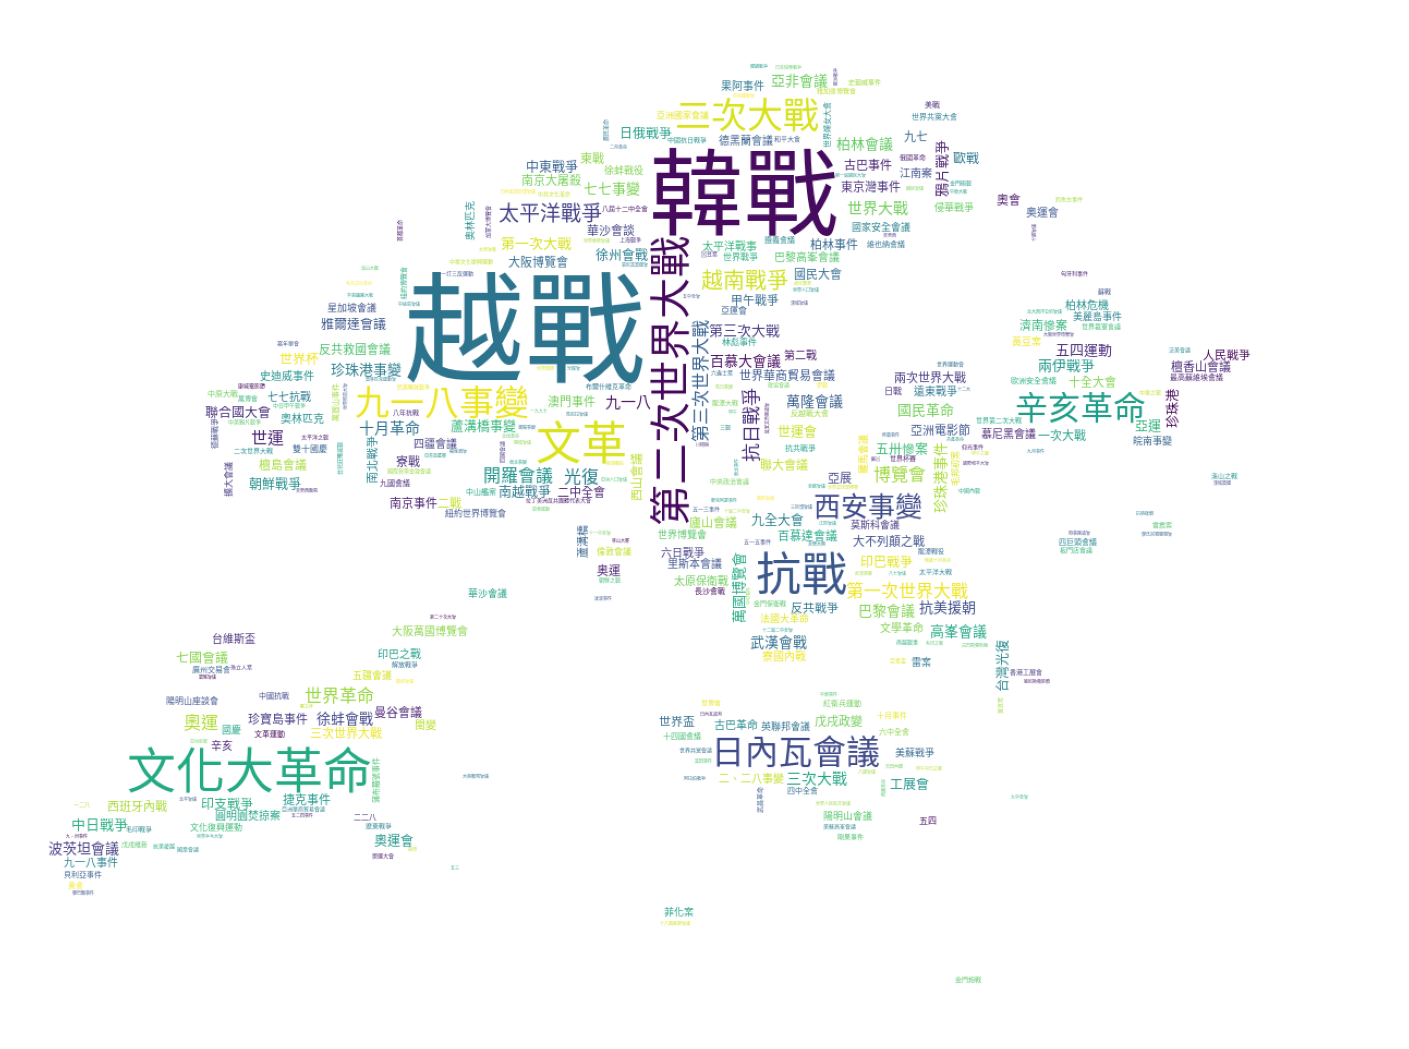

In [ ]:
# RE-Organized ver 

font = "/content/NotoSansTC-Regular.otf"

hkpng = 'https://dsprojects.lib.cuhk.edu.hk/media/filer_public/c6/f4/c6f4ddce-43c1-476d-b2ae-91ad1f4ce66b/hkampppppppppppppppppppp.png'

image_ulr = urlretrieve(hkpng, "sample.png")
icon = Image.open("sample.png")

mask= Image.new("RGB", icon.size, (1000, 1000, 1000))
mask.paste(icon,icon)
mask = np.array(mask)

wc = WordCloud(font_path = font, background_color = "white", max_words = None, mask = mask, random_state = 1)
wc.generate_from_frequencies(temp_type_gpe_dict)
image_colors = ImageColorGenerator(mask)
plt.axis("off") 
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(wc)

